# Module 1: Importing required libraries ###

In [1]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import statistics as st
import math
import scipy.stats as stats
import matplotlib.mlab as mlab
from scipy.stats import norm
import sys
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from  sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
import warnings
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report


C:\Users\vijay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\vijay\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import sklearn

In [3]:
sns.set(style="whitegrid")
sns.set_style("ticks")
warnings.filterwarnings("ignore")

# Module 2: Exploratory Data Analysis ###

In [4]:
data = pd.read_csv('predictive_maintenance.csv')

###### Checking the shape of the data to understand the number of null values 

In [5]:
data.shape

(124494, 12)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date       124494 non-null object
device     124494 non-null object
failure    124494 non-null int64
metric1    124494 non-null int64
metric2    124494 non-null int64
metric3    124494 non-null int64
metric4    124494 non-null int64
metric5    124494 non-null int64
metric6    124494 non-null int64
metric7    124494 non-null int64
metric8    124494 non-null int64
metric9    124494 non-null int64
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [7]:
data.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


###### Coverting date column into date type 

In [8]:
##### Converting date column to datetime ###
data['date']= pd.to_datetime(data['date'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date       124494 non-null datetime64[ns]
device     124494 non-null object
failure    124494 non-null int64
metric1    124494 non-null int64
metric2    124494 non-null int64
metric3    124494 non-null int64
metric4    124494 non-null int64
metric5    124494 non-null int64
metric6    124494 non-null int64
metric7    124494 non-null int64
metric8    124494 non-null int64
metric9    124494 non-null int64
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


In [10]:
###### Looking into the range of date to understand about the period of the data given

In [11]:
print('Maximum date: ',data['date'].max(),'\nMinimum date',data['date'].min(),'\nTotal length of period',data['date'].nunique())

Maximum date:  2015-11-02 00:00:00 
Minimum date 2015-01-01 00:00:00 
Total length of period 304


###### Looking into the number of devices throughout the date periods.
###### The graph shows that the number of devices decreases with increase in dates

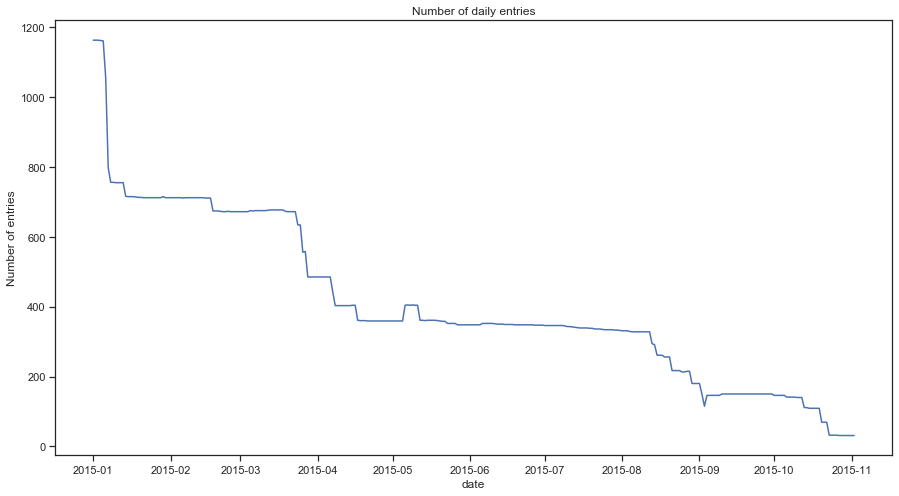

In [12]:
df_1 = pd.DataFrame(data.groupby(['date']).count()['device'])
df_1.reset_index(inplace=True)
plt.figure(figsize=(15,8))
ax= plt.subplot()
sns.lineplot(x="date", y="device",  markers=True, dashes=False, data=df_1)
# labels, title and ticks
ax.set_xlabel('date');ax.set_ylabel('Number of entries'); 
ax.set_title('Number of daily entries'); 


In [13]:
tot_dev = data.device.nunique()
survived_devices = data[data.date== max(data.date)].device.drop_duplicates().reset_index(drop = True)
#data[data.date== min(data.date) & data['device'].isin(survived_devices)]
starting_dev = data[(data['device'].isin(survived_devices)) & (data.date== min(data.date))].device
survived_devices.shape[0] - starting_dev.shape[0]

0

In [14]:
max(data.date)

Timestamp('2015-11-02 00:00:00')

###### Counting the number of days each device has survived for

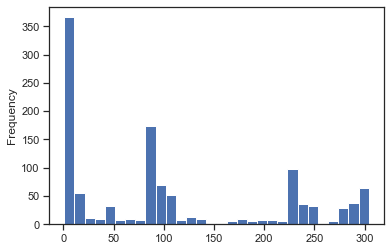

In [15]:
pd.DataFrame(data.groupby(['device']).count()['date']).reset_index().date.plot.hist(bins=30)

###### Looking into the devices which are removed vs the devices which have failed
Even though 97.3% of the total devices are removed, only 9.3% of the removed devices failed

In [16]:
number_fails = data.failure.sum()
pct_removed = 1-survived_devices.shape[0]/tot_dev 
pct_removed_fails =number_fails/(tot_dev-survived_devices.shape[0])
print(number_fails,pct_removed ,pct_removed_fails)

106 0.9734816082121471 0.09314586994727592


In [17]:
number_fails

106

###### Checking if the devices which failed, they failed only once

In [18]:
fail_agg = data.sort_values('date').groupby(['device']).aggregate({'failure':'sum','date':'max'}).reset_index()
fail_agg =fail_agg[fail_agg.failure > 0]
fail_last = data.sort_values('date').groupby('device').tail(1)[['device','failure']]
fail_last['flag']=np.where(fail_last['failure']==1,1,0)
fail_last.drop(['failure'], axis = 1, inplace = True)
fail_agg = pd.merge(fail_agg,fail_last)
fail_agg.failure.max() ==1

True

###### percent of failures that happened on the last log entry

In [19]:
fail_agg.flag.sum()/fail_agg.shape[0]

0.9528301886792453

###### Devices which have log entries even after they fail

In [20]:
live_after_fail = fail_agg['device'][fail_agg.flag ==0]
live_after_fail

10    S1F0GPFZ
40    S1F136J0
49    W1F0KCP2
50    W1F0M35B
69    W1F11ZG9
Name: device, dtype: object

In [21]:
req_live_after_fail = data[(data['device'].isin(live_after_fail))]

###### Looking into the cummulative number of failures over time. This gets constant after August

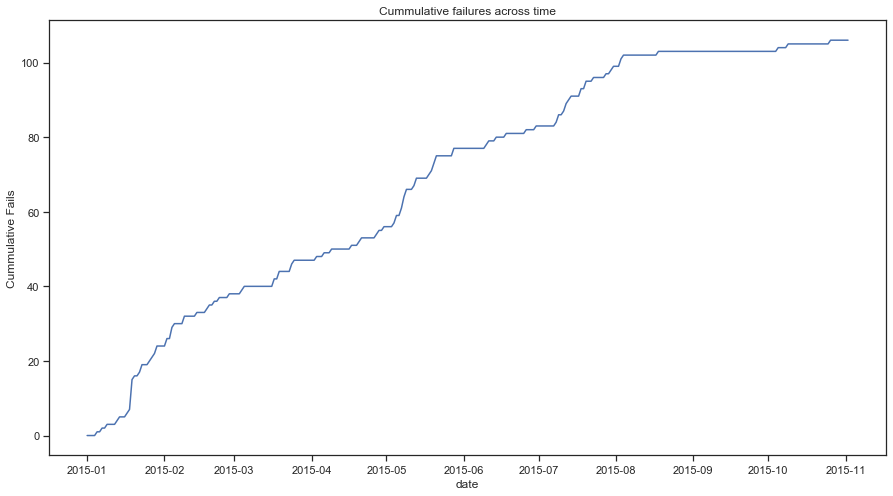

In [22]:
failure_sum = data.groupby(['date']).aggregate({'failure':'sum'}).reset_index()
plt.figure(figsize=(15,8))
ax= plt.subplot()
sns.lineplot(failure_sum.date,failure_sum.failure.cumsum(),  markers=True, dashes=False, data=df_1)
# labels, title and ticks
ax.set_xlabel('date');ax.set_ylabel('Cummulative Fails'); 
ax.set_title('Cummulative failures across time'); 



In [23]:
data= data.sort_values('date')

###### Looking into the confidence interval of the attributes

In [24]:
cols = list(data.columns.values)
cols.remove('date')
cols.remove('device')
ci =[]
for i,column in enumerate(cols):
    Confidence_Interval = stats.norm.interval(0.05,data[column].mean(),scale=data[column].std())
    ci.append(Confidence_Interval)
ci = pd.DataFrame(ci)
ci['column']= cols
ci.rename(columns={0:'LCI',1:'HCI'}, inplace = True)
print(ci)

            LCI           HCI   column
0 -9.775377e-04  2.680431e-03  failure
1  1.179698e+08  1.268064e+08  metric1
2  2.280545e+01  2.961641e+02  metric2
3 -1.707161e+00  2.158807e+01  metric3
4  3.046014e-01  3.177639e+00  metric4
5  1.322293e+01  1.522241e+01  metric5
6  2.539552e+05  2.663901e+05  metric6
7 -1.738174e-01  7.588737e-01  metric7
8 -1.738174e-01  7.588737e-01  metric8
9  4.478397e-01  2.445521e+01  metric9


###### Box plot of the metrics to understand their range and outliers if any. These outliers may indicate the failure of a device

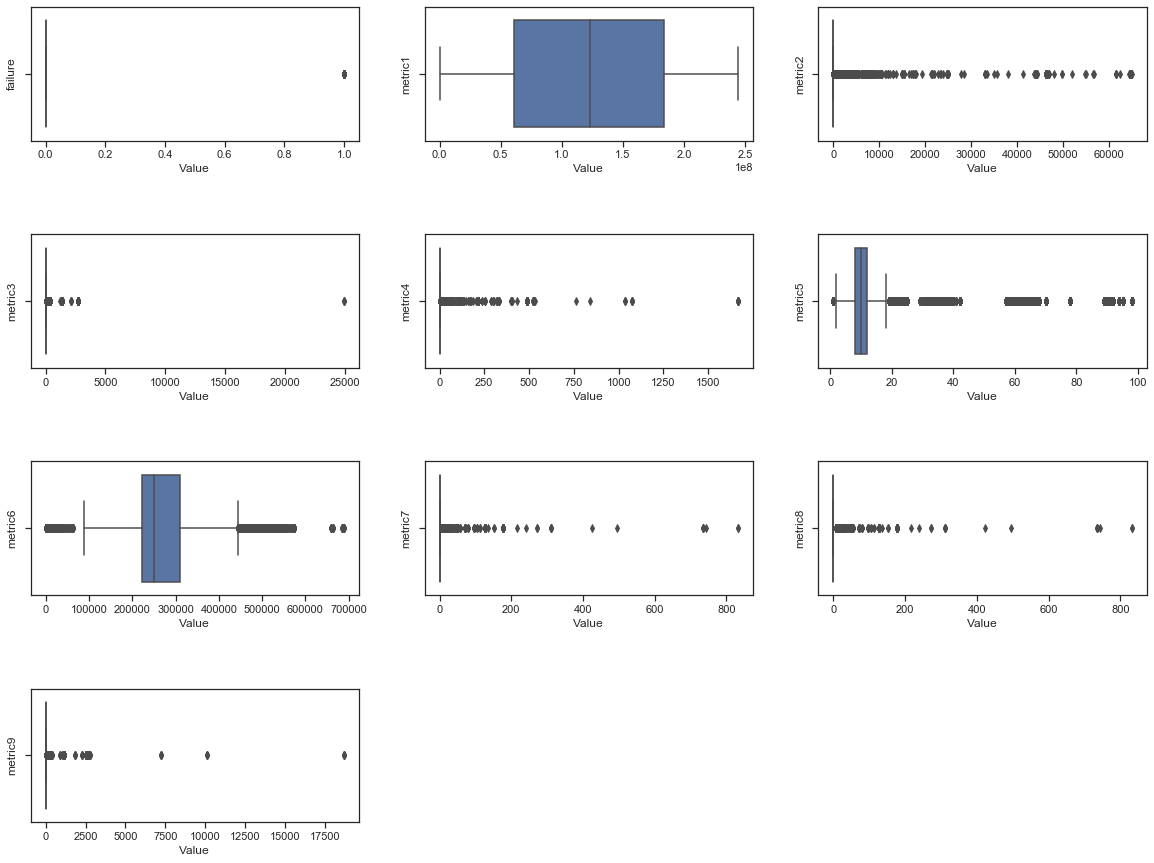

In [25]:
fig = plt.figure(figsize=(20,15))
cols_val = 3
rows = math.ceil(float(data.shape[1]) / cols_val)
for i, column in enumerate(cols):
    ax = fig.add_subplot(rows, cols_val, i + 1)
    sns.boxplot(x=data[column])
    plt.ylabel(column)
    plt.xlabel('Value')
plt.subplots_adjust(hspace=0.7, wspace=0.2)

###### Histogram to understand the spread of the data metrics

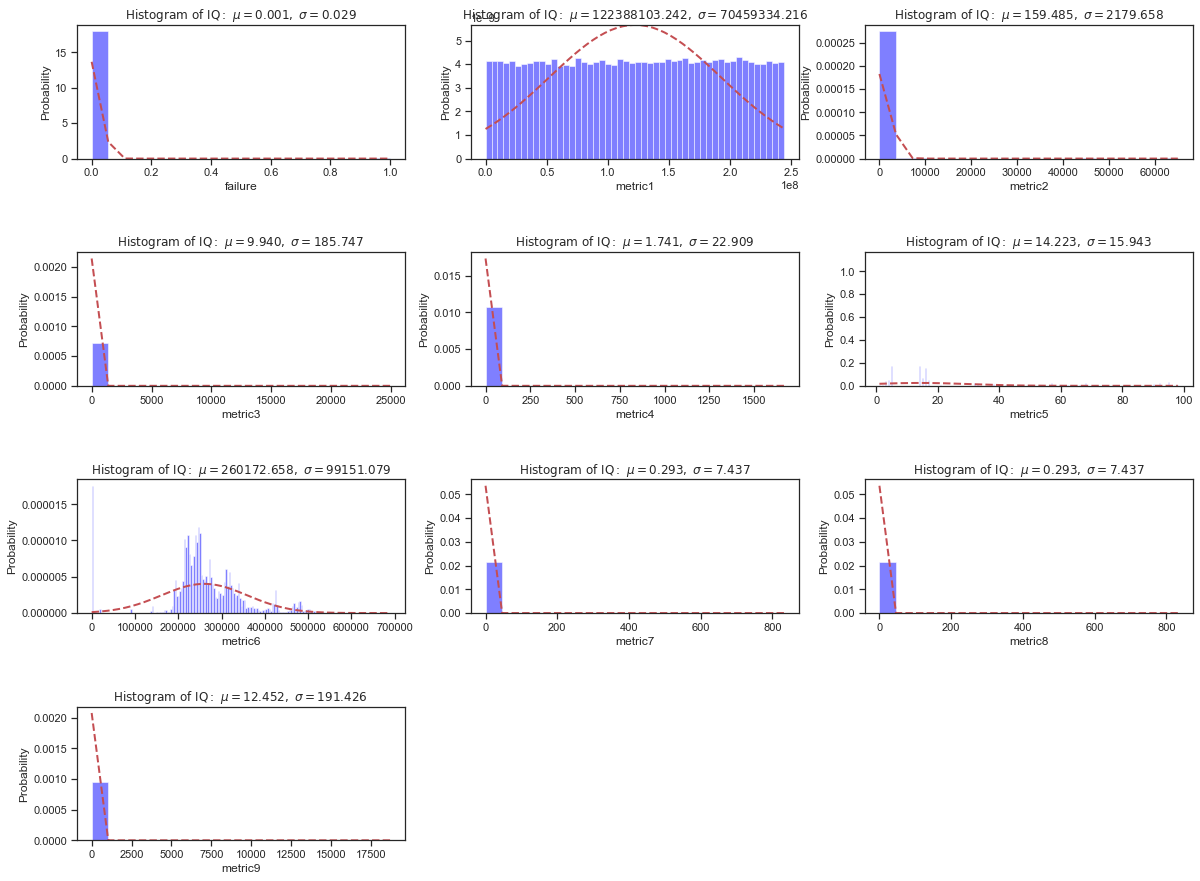

In [26]:
fig = plt.figure(figsize=(20,15))
cols_val = 3
rows = math.ceil(float(data.shape[1]) / cols_val)
for i, column in enumerate(cols):
    ax = fig.add_subplot(rows, cols_val, i + 1)
    h = data[column]
    mu = h.mean()
    sigma = h.std()
    n, bins, patches = plt.hist(h, 'auto', normed=1, facecolor='blue', alpha=0.5)
    # add a 'best fit' line
    y =  norm.pdf(bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth=2)
    #plt.plot(bins, y, 'r--')
    plt.xlabel(column)
    plt.ylabel('Probability')
    plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))

plt.subplots_adjust(hspace=0.7, wspace=0.2)

# Module 3: Feature Engineering ###

In [27]:
data_metrics =data[['device','metric1','metric2','metric3','metric4','metric5','metric6','metric7','metric8','metric9']]

###### Correlation between the metrics
###### Metrics 7 and 8 are exactly correlated to each other. Also,their values are same. Hence, dropping one of these metrics

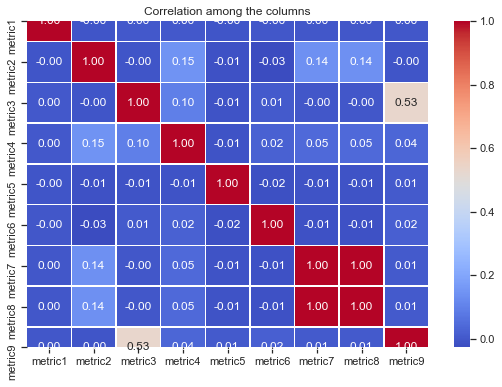

In [28]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_metrics.corr(), cmap ='coolwarm',annot=True,fmt='.2f',ax=ax, linewidths=.5)
plt.title('Correlation among the columns')
plt.show()

In [29]:
######### removing correlated columns ######
corr_matrix = data_metrics.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
data_metrics.drop(to_drop, axis=1, inplace = True)

In [30]:
print('Metric which is dropepd is: ',to_drop)

Metric which is dropepd is:  ['metric8']


In [31]:
data_metrics.head()

,device,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,S1F01085,215630672,56,0,52,6,407438,0,7
779,W1F0Y13C,234318640,0,0,0,4,185772,0,3
778,W1F0XKWR,89660704,0,0,0,7,30,0,0
777,W1F0X7QX,162013456,0,0,0,12,217686,0,0
776,W1F0X7PR,13138392,0,0,0,9,191343,0,0


###### Aggregating data at device level


At Device x Attribute level:
    1. Mean - To capture the average value of the attribute
    2. Standard Deviation- To capture the variation in the values from the mean
    3. Last value - To capture the last value of the attribute in the log for understanding the behaviour at which the device failed or was just removed
    4. Range - To capture the spread of the attribute

Device level:
    1. Maximum gap of days between the entries of the device in the gap
    2. Number of entries for each device

In [32]:
metric_collapsing = data_metrics.groupby(['device']).aggregate([('std','std'),('mean','mean'),('last',lambda x: x.tail(1)),('drift',lambda x: (x.tail(1).values - x.head(1).values)[0])]).reset_index()
metric_collapsing.columns = metric_collapsing.columns.map('_'.join).str.strip('_')

In [33]:
metric_collapsing.head()

,device,metric1_std,metric1_mean,metric1_last,metric1_drift,metric2_std,metric2_mean,metric2_last,metric2_drift,metric3_std,...,metric6_last,metric6_drift,metric7_std,metric7_mean,metric7_last,metric7_drift,metric9_std,metric9_mean,metric9_last,metric9_drift
0,S1F01085,6.888088e+07,1.159330e+08,128832128,-86798544,0.0,56.0,56,0,0.0,...,409404,1966,0.0,0.0,0,0,0.0,7.0,7,0
1,S1F013BB,9.157123e+07,1.198783e+08,115676688,101142720,0.0,0.0,0,0,0.0,...,689161,209,0.0,0.0,0,0,0.0,0.0,0,0
2,S1F0166B,8.300793e+07,1.074958e+08,7441792,-53928888,0.0,0.0,0,0,0.0,...,404786,1612,0.0,0.0,0,0,0.0,0.0,0,0
3,S1F01E6Y,6.818503e+07,1.331127e+08,147350000,-25945968,0.0,0.0,0,0,0.0,...,259491,22097,0.0,0.0,0,0,0.0,0.0,0,0
4,S1F01JE0,6.441321e+07,1.673001e+08,185424928,105730904,0.0,0.0,0,0,0.0,...,412151,1965,0.0,0.0,0,0,0.0,0.0,0,0


In [34]:
other_features = data.groupby(['device']).aggregate({'failure':[("failure",'max'),('cnt','count')],"date":[('gap',lambda x: np.nanmax(x.diff().dt.days))]}).reset_index()
other_features.columns = other_features.columns.map('_'.join).str.strip('_')

In [35]:
total_data = pd.merge(other_features,metric_collapsing)

In [36]:
total_data.rename(columns={'failure_failure':'failure','failure_cnt':'number_of_rows'}, inplace = True)

In [37]:
total_data.head()

,device,failure,number_of_rows,date_gap,metric1_std,metric1_mean,metric1_last,metric1_drift,metric2_std,metric2_mean,...,metric6_last,metric6_drift,metric7_std,metric7_mean,metric7_last,metric7_drift,metric9_std,metric9_mean,metric9_last,metric9_drift
0,S1F01085,0,6,1.0,6.888088e+07,1.159330e+08,128832128,-86798544,0.0,56.0,...,409404,1966,0.0,0.0,0,0,0.0,7.0,7,0
1,S1F013BB,0,6,1.0,9.157123e+07,1.198783e+08,115676688,101142720,0.0,0.0,...,689161,209,0.0,0.0,0,0,0.0,0.0,0,0
2,S1F0166B,0,6,1.0,8.300793e+07,1.074958e+08,7441792,-53928888,0.0,0.0,...,404786,1612,0.0,0.0,0,0,0.0,0.0,0,0
3,S1F01E6Y,0,48,1.0,6.818503e+07,1.331127e+08,147350000,-25945968,0.0,0.0,...,259491,22097,0.0,0.0,0,0,0.0,0.0,0,0
4,S1F01JE0,0,6,1.0,6.441321e+07,1.673001e+08,185424928,105730904,0.0,0.0,...,412151,1965,0.0,0.0,0,0,0.0,0.0,0,0


In [38]:
total_data.describe()

,failure,number_of_rows,date_gap,metric1_std,metric1_mean,metric1_last,metric1_drift,metric2_std,metric2_mean,metric2_last,...,metric6_last,metric6_drift,metric7_std,metric7_mean,metric7_last,metric7_drift,metric9_std,metric9_mean,metric9_last,metric9_drift
count,1169.000000,1169.000000,1168.000000,1.168000e+03,1.169000e+03,1.169000e+03,1.169000e+03,1168.000000,1169.000000,1169.000000,...,1169.000000,1169.000000,1168.000000,1169.000000,1169.000000,1169.000000,1168.000000,1169.000000,1169.000000,1169.000000
mean,0.090676,106.496151,6.813356,6.761023e+07,1.232700e+08,1.221612e+08,1.168870e+05,173.558101,501.401434,872.260051,...,269958.996578,31311.771600,0.906885,1.000321,4.443114,3.803251,0.075916,49.149451,49.230967,0.178785
std,0.287270,102.651601,21.579198,1.447440e+07,2.137373e+07,7.040220e+07,9.996224e+07,1686.888067,4258.826753,5990.879345,...,104615.250090,36528.773196,8.983024,10.468445,43.725859,42.626351,0.786921,678.121965,678.117966,1.608952
min,0.000000,1.000000,1.000000,8.503654e+06,2.625001e+07,0.000000e+00,-2.360442e+08,0.000000,0.000000,0.000000,...,12.000000,0.000000,0.000000,0.000000,0.000000,-8.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.000000,1.000000,6.647255e+07,1.165788e+08,5.972926e+07,-7.635162e+07,0.000000,0.000000,0.000000,...,212306.000000,2484.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,84.000000,1.000000,7.011835e+07,1.225670e+08,1.222921e+08,3.271216e+06,0.000000,0.000000,0.000000,...,261020.000000,23428.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,224.000000,1.000000,7.294776e+07,1.287887e+08,1.826172e+08,8.157074e+07,0.000000,0.000000,0.000000,...,328098.000000,46643.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,304.000000,143.000000,1.079201e+08,2.318134e+08,2.433294e+08,2.367804e+08,28514.580988,64780.444444,64792.000000,...,689161.000000,180657.000000,231.641254,312.000000,832.000000,832.000000,19.839355,18701.000000,18701.000000,38.000000


In [39]:
total_data.head()

,device,failure,number_of_rows,date_gap,metric1_std,metric1_mean,metric1_last,metric1_drift,metric2_std,metric2_mean,...,metric6_last,metric6_drift,metric7_std,metric7_mean,metric7_last,metric7_drift,metric9_std,metric9_mean,metric9_last,metric9_drift
0,S1F01085,0,6,1.0,6.888088e+07,1.159330e+08,128832128,-86798544,0.0,56.0,...,409404,1966,0.0,0.0,0,0,0.0,7.0,7,0
1,S1F013BB,0,6,1.0,9.157123e+07,1.198783e+08,115676688,101142720,0.0,0.0,...,689161,209,0.0,0.0,0,0,0.0,0.0,0,0
2,S1F0166B,0,6,1.0,8.300793e+07,1.074958e+08,7441792,-53928888,0.0,0.0,...,404786,1612,0.0,0.0,0,0,0.0,0.0,0,0
3,S1F01E6Y,0,48,1.0,6.818503e+07,1.331127e+08,147350000,-25945968,0.0,0.0,...,259491,22097,0.0,0.0,0,0,0.0,0.0,0,0
4,S1F01JE0,0,6,1.0,6.441321e+07,1.673001e+08,185424928,105730904,0.0,0.0,...,412151,1965,0.0,0.0,0,0,0.0,0.0,0,0


In [40]:
total_data.dropna(axis=0, inplace= True)

In [41]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 0 to 1168
Data columns (total 36 columns):
device            1168 non-null object
failure           1168 non-null int64
number_of_rows    1168 non-null int64
date_gap          1168 non-null float64
metric1_std       1168 non-null float64
metric1_mean      1168 non-null float64
metric1_last      1168 non-null int64
metric1_drift     1168 non-null int64
metric2_std       1168 non-null float64
metric2_mean      1168 non-null float64
metric2_last      1168 non-null int64
metric2_drift     1168 non-null int64
metric3_std       1168 non-null float64
metric3_mean      1168 non-null float64
metric3_last      1168 non-null int64
metric3_drift     1168 non-null int64
metric4_std       1168 non-null float64
metric4_mean      1168 non-null float64
metric4_last      1168 non-null int64
metric4_drift     1168 non-null int64
metric5_std       1168 non-null float64
metric5_mean      1168 non-null float64
metric5_last      1168 non-null in

In [42]:
device_name=total_data[['device']]
total_data.drop(['device'], axis=1, inplace = True)

###### Splitting the data into independent and dependent variable

In [43]:
y_data=total_data[['failure']]
X_data=total_data
X_data.drop(['failure'], axis=1, inplace = True)

# Module 4: Class Imbalance ###

#Checking the class imbalance to understand the type of scoring metrics to be used for determining the best model 

In [44]:
print('Proportion of 0:',round(len(y_data[y_data.failure == 0])/ len(y_data)*100,2))
print("Proportion of 1:",round(len(y_data[y_data.failure == 1])/ len(y_data)*100,2))

Proportion of 0: 90.92
Proportion of 1: 9.08


# Module 5: Split Data into Train and Test ###

In [87]:
from sklearn.model_selection import train_test_split
X_data_train,X_data_test, y_data_train, y_data_test = train_test_split(X_data, y_data, shuffle = True, test_size = 0.30, random_state=42)

In [94]:
test_indx = pd.DataFrame(X_data_test.index, columns=['idx'])

In [95]:
test_indx.index = test_indx.idx

# Module 6: Synthetically increases the minority class of failures (SMOTE) ###

In [46]:
data_train_X =X_data_train
data_train_y = y_data_train
columns = data_train_X.columns
os =SMOTE(random_state=25)
os_data_X,os_data_y=os.fit_sample(data_train_X,data_train_y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=["failure"])
print("length of oversampled data is ",len(os_data_X))
print("Number of rows with no failure",len(os_data_y[os_data_y["failure"]==0]))
print("Number of rows with failure",len(os_data_y[os_data_y["failure"]==1]))
print("Proportion of Normal data in oversampled data is ",len(os_data_y[os_data_y["failure"]==0])/len(os_data_X))
print("Proportion of undersampled data in oversampled data is ",len(os_data_y[os_data_y["failure"]==1])/len(os_data_X))
X_data_train =os_data_X
y_data_train=os_data_y

length of oversampled data is  1488
Number of rows with no failure 744
Number of rows with failure 744
Proportion of Normal data in oversampled data is  0.5
Proportion of undersampled data in oversampled data is  0.5


# Module 7: Normalization of independent features ###

In [47]:
scaler = MinMaxScaler()
X_data_train = scaler.fit_transform(X_data_train)
X_data_test = scaler.fit_transform(X_data_test)

# Module 8: Initiallizing the hyper-parametrs

In [48]:
param_grid_lg= {"penalty":['l1', 'l2'], "C":[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
param_grid_svc={'C':[0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_dt= {'max_depth': [2, 6, 10, 15, 20]}
param_grid_rf= {'n_estimators':[200,350,500,700], 'max_depth':[2,6,10,15,20]}
param_grid_gb = {'n_estimators':[200,350,500], 'max_depth':[2,6,10,15,20],'learning_rate':[0.01,0.1,1,10]}


# Module 9: Training machine learning models

###### Function to train models

In [49]:
def model(X_train, y_train,param_grid,estimator,scoring_type):
    grid = GridSearchCV(estimator, param_grid = param_grid, cv = 10, scoring = scoring_type)
    grid.fit(X_train, y_train)
    return (grid)

###### Calling function to train different machine learning models using various scoring techniques

In [53]:
grid_lg_p = model(X_data_train, y_data_train,param_grid_lg,linear_model.LogisticRegression(),'precision')
grid_lg_r = model(X_data_train, y_data_train,param_grid_lg,linear_model.LogisticRegression(),'recall')
grid_lg_f = model(X_data_train, y_data_train,param_grid_lg,linear_model.LogisticRegression(),'f1')
grid_svc_p = model(X_data_train, y_data_train,param_grid_svc,LinearSVC(),'precision')
grid_svc_r = model(X_data_train, y_data_train,param_grid_svc, LinearSVC(),'recall')
grid_svc_f = model(X_data_train, y_data_train,param_grid_svc, LinearSVC(),'f1')
grid_dt_p = model(X_data_train, y_data_train,param_grid_dt,DecisionTreeClassifier(),'precision')
grid_dt_r = model(X_data_train, y_data_train,param_grid_dt, DecisionTreeClassifier(),'recall')
grid_dt_f = model(X_data_train, y_data_train,param_grid_dt, DecisionTreeClassifier(),'f1')
grid_rf_p = model(X_data_train, y_data_train,param_grid_rf,RandomForestClassifier(),'precision')
grid_rf_r = model(X_data_train, y_data_train,param_grid_rf, RandomForestClassifier(),'recall')
grid_rf_f = model(X_data_train, y_data_train,param_grid_rf, RandomForestClassifier(),'f1')
grid_gb_p = model(X_data_train, y_data_train,param_grid_gb,GradientBoostingClassifier(),'precision')
grid_gb_r = model(X_data_train, y_data_train,param_grid_gb, GradientBoostingClassifier(),'recall')
grid_gb_f = model(X_data_train, y_data_train,param_grid_gb, GradientBoostingClassifier(),'f1')
grid_et_p = model(X_data_train, y_data_train,param_grid_rf,ExtraTreesClassifier(),'precision')
grid_et_r = model(X_data_train, y_data_train,param_grid_rf, ExtraTreesClassifier(),'recall')
grid_et_f = model(X_data_train, y_data_train,param_grid_rf,ExtraTreesClassifier(),'f1')


# Module 10: Evaluating the results of the models on train data 

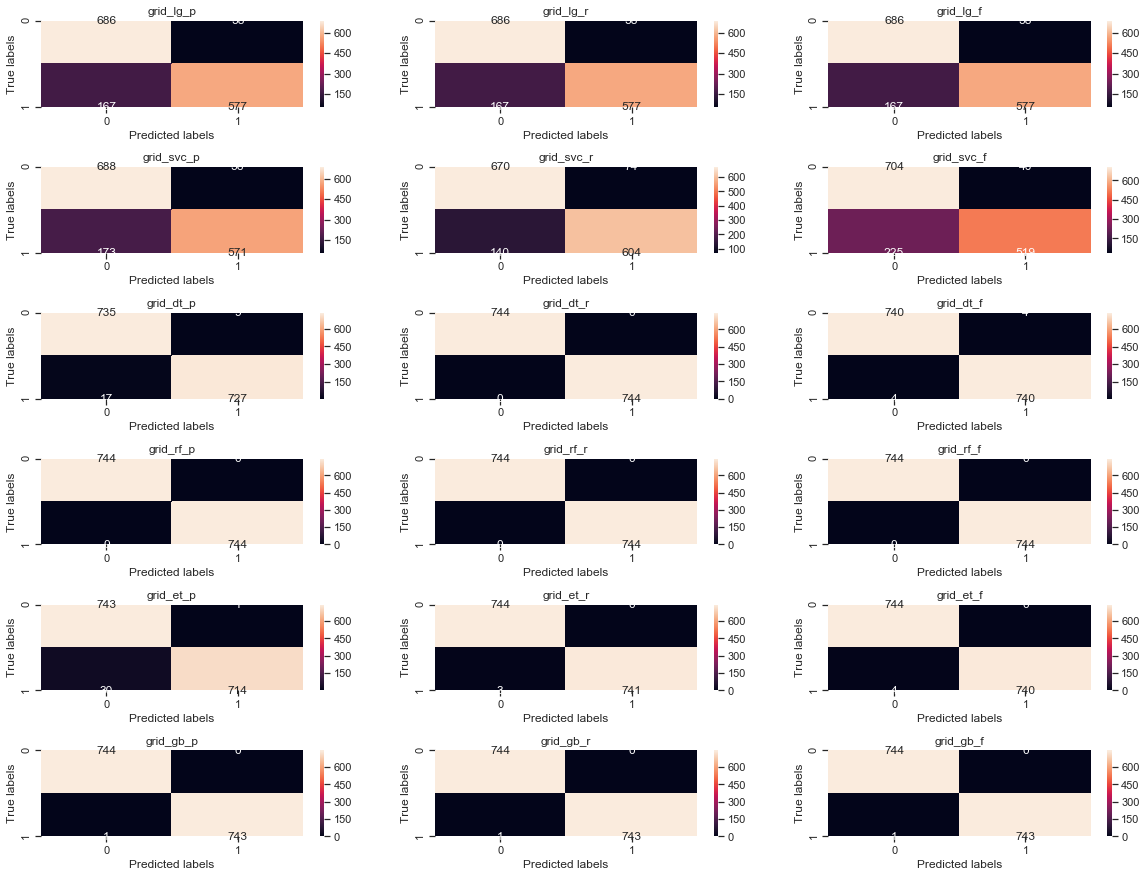

In [54]:
labels = [0,1]
fig = plt.figure(figsize=(20,15))
cols_val = 3
rows = 6
mod1=['grid_lg_p','grid_lg_r','grid_lg_f','grid_svc_p','grid_svc_r','grid_svc_f','grid_dt_p','grid_dt_r','grid_dt_f','grid_rf_p','grid_rf_r','grid_rf_f','grid_et_p','grid_et_r','grid_et_f', 'grid_gb_p','grid_gb_r','grid_gb_f']
mod=[grid_lg_p,grid_lg_r,grid_lg_f,grid_svc_p,grid_svc_r,grid_svc_f,grid_dt_p,grid_dt_r,grid_dt_f,grid_rf_p,grid_rf_r,grid_rf_f,grid_et_p,grid_et_r,grid_et_f,grid_gb_p,grid_gb_r,grid_gb_f]
for i, model_data in enumerate(mod):
    ax = fig.add_subplot(rows, cols_val, i + 1)
    model_pred =model_data.predict(X_data_train)
    cm = confusion_matrix(y_data_train, model_pred,labels)
    sns.heatmap(cm, annot=True, fmt='g'); #annot=True to annotate cells
   # labels, title and ticks

    plt.xlabel('Predicted labels');plt.ylabel('True labels');

    plt.title(mod1[i]);

    #ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);
    
plt.subplots_adjust(hspace=0.7, wspace=0.2)


# Module 11: Evaluating the results of the models on test data 

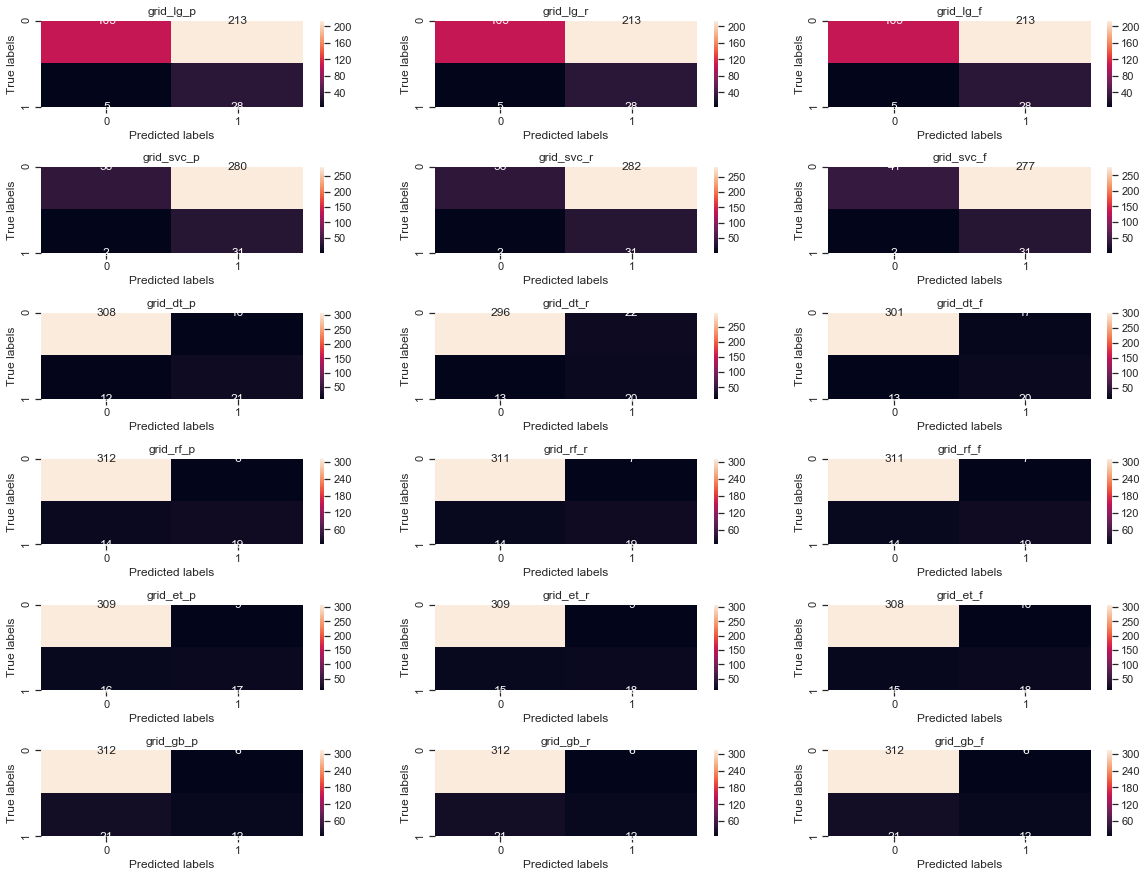

In [55]:
labels = [0,1]
fig = plt.figure(figsize=(20,15))
cols_val = 3
rows = 6
mod1=['grid_lg_p','grid_lg_r','grid_lg_f','grid_svc_p','grid_svc_r','grid_svc_f','grid_dt_p','grid_dt_r','grid_dt_f','grid_rf_p','grid_rf_r','grid_rf_f','grid_et_p','grid_et_r','grid_et_f', 'grid_gb_p','grid_gb_r','grid_gb_f']
mod=[grid_lg_p,grid_lg_r,grid_lg_f,grid_svc_p,grid_svc_r,grid_svc_f,grid_dt_p,grid_dt_r,grid_dt_f,grid_rf_p,grid_rf_r,grid_rf_f,grid_et_p,grid_et_r,grid_et_f,grid_gb_p,grid_gb_r,grid_gb_f]
for i, model_data in enumerate(mod):
    ax = fig.add_subplot(rows, cols_val, i + 1)
    model_pred =model_data.predict(X_data_test)
    cm = confusion_matrix(y_data_test, model_pred,labels)
    sns.heatmap(cm, annot=True, fmt='g'); #annot=True to annotate cells
   # labels, title and ticks

    plt.xlabel('Predicted labels');plt.ylabel('True labels');

    plt.title(mod1[i]);

    #ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);
    
plt.subplots_adjust(hspace=0.7, wspace=0.2)


###### Confusion Matrix for test data outputs of the models
###### Random Forest with f1 score as scoring parameters seems to work the best for this data set

###### Classification report for the test data results across models to analyze the precision, recall and f1 score

In [56]:
final_table =pd.DataFrame()

In [57]:
def classification_rep(model):
    report = classification_report(y_data_test, model.predict(X_data_test), target_names=["0", "1"], output_dict=True)
    return(pd.DataFrame(report).transpose())
    
    

In [58]:
mod1=['grid_lg_p','grid_lg_r','grid_lg_f','grid_svc_p','grid_svc_r','grid_svc_f','grid_dt_p','grid_dt_r','grid_dt_f','grid_rf_p','grid_rf_r','grid_rf_f','grid_et_p','grid_et_r','grid_et_f', 'grid_gb_p','grid_gb_r','grid_gb_f']
mod=[grid_lg_p,grid_lg_r,grid_lg_f,grid_svc_p,grid_svc_r,grid_svc_f,grid_dt_p,grid_dt_r,grid_dt_f,grid_rf_p,grid_rf_r,grid_rf_f,grid_et_p,grid_et_r,grid_et_f,grid_gb_p,grid_gb_r,grid_gb_f]


In [59]:
for i, model_data in enumerate(mod):
    report = classification_report(y_data_test, model_data.predict(X_data_test), target_names=["0", "1"], output_dict=True)
    repo= pd.DataFrame(report).transpose()
    columns=[(mod1[i],'f1-score'),(mod1[i],'predicion'),(mod1[i],'recall'), (mod1[i],'support')]
    repo.columns=pd.MultiIndex.from_tuples(columns)
    final_table = pd.concat([final_table,repo], axis = 1)
    
    

In [60]:
final_table

grid_lg_p                                 grid_lg_r            \
              f1-score predicion    recall     support  f1-score predicion   
0             0.490654  0.954545  0.330189  318.000000  0.490654  0.954545   
1             0.204380  0.116183  0.848485   33.000000  0.204380  0.116183   
accuracy      0.378917  0.378917  0.378917    0.378917  0.378917  0.378917   
macro avg     0.347517  0.535364  0.589337  351.000000  0.347517  0.535364   
weighted avg  0.463739  0.875725  0.378917  351.000000  0.463739  0.875725   

                                   grid_lg_f            ... grid_gb_p  \
                recall     support  f1-score predicion  ...    recall   
0             0.330189  318.000000  0.490654  0.954545  ...  0.981132   
1             0.848485   33.000000  0.204380  0.116183  ...  0.363636   
accuracy      0.378917    0.378917  0.378917  0.378917  ...  0.923077   
macro avg     0.589337  351.000000  0.347517  0.535364  ...  0.672384   
weighted avg  0.378917  351.000000  0.463739  0.875725  ...  0.923077   

                         grid_gb_r                                 grid_gb_f  \
                 support  f1-score predicion    recall     support  f1-score   
0             318.000000  0.958525  0.936937  0.981132  318.000000  0.958525   
1              33.000000  0.470588  0.666667  0.363636   33.000000  0.470588   
accuracy        0.923077  0.923077  0.923077  0.923077    0.923077  0.923077   
macro avg     351.000000  0.714557  0.801802  0.672384  351.000000  0.714557   
weighted avg  351.000000  0.912651  0.911527  0.923077  351.000000  0.912651   

                                              
             predicion    recall     support  
0             0.936937  0.981132  318.000000  
1             0.666667  0.363636   33.000000  
accuracy      0.923077  0.923077    0.923077  
macro avg     0.801802  0.672384  351.000000  
weighted avg  0.911527  0.923077  351.000000  

[5 rows x 72 columns]

In [61]:
final_table.to_csv('model_output_table_v4.csv')

# Module 12: Model Tuning

###### Best parameters of the chosen model

In [62]:
grid_rf_f.best_params_

{'max_depth': 15, 'n_estimators': 500}

###### Re-training the chosen model with the best parameters

In [66]:
grid_rf_f_req = RandomForestClassifier(max_depth=15,n_estimators=500)

In [67]:
grid_rf_f_req.fit(X_data_train,y_data_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

###### Feature importance to find the important features

###### Feature importance using Random Forest feature importance

In [68]:
features=pd.DataFrame(X_data.columns,columns=['features'])
score=pd.DataFrame(grid_rf_f_req.feature_importances_,columns=['score'])
feature_matrix_RF=pd.concat([features,score],axis=1)
feature_matrix_RF.sort_values('score',ascending=False, inplace = True)


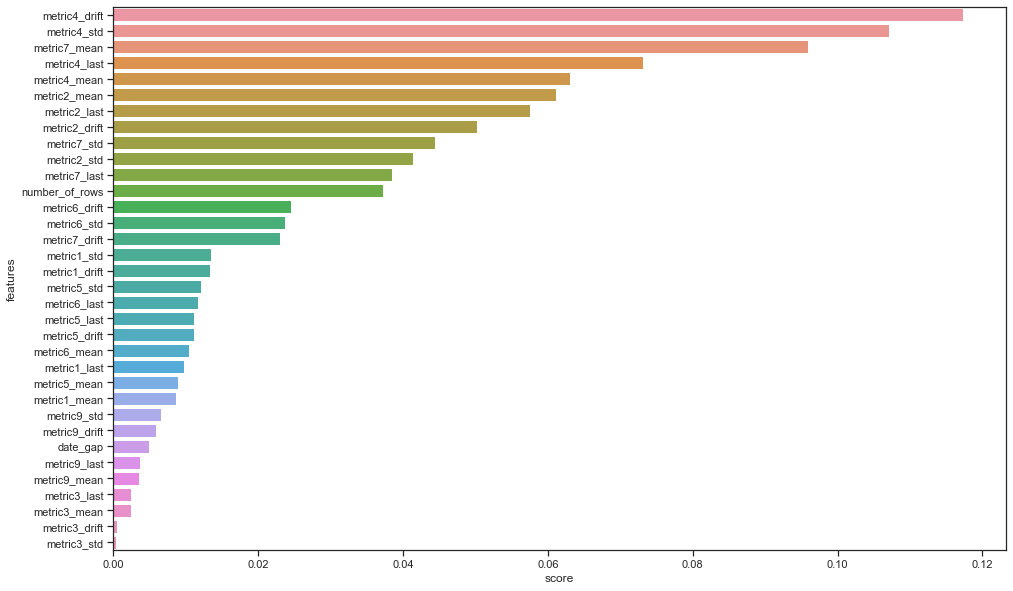

In [69]:
f, ax = plt.subplots(figsize=(16,10))
ax = sns.barplot(x="score", y="features", data=feature_matrix_RF)

In [70]:
req_features = pd.DataFrame(feature_matrix_RF['features'][feature_matrix_RF.score >=0.02])

In [71]:
req_features = pd.DataFrame(feature_matrix_RF['features'].head(10))

In [72]:
req_index = pd.merge(pd.DataFrame(X_data.columns,columns=['features']).reset_index(), req_features)[['index']]

In [73]:
req_X_data_train = X_data_train[:,list(req_index.iloc[:,0])]
req_X_data_test = X_data_test[:,list(req_index.iloc[:,0])]

In [74]:
grid_rf_f_req.fit(req_X_data_train,y_data_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[[297  21]
 [ 16  17]]


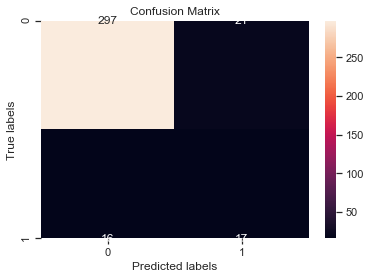

In [75]:
cm = confusion_matrix(y_data_test, grid_rf_f_req.predict(req_X_data_test),labels)

print(cm)

ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax,fmt='g'); #annot=True to annotate cells


# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

ax.set_title('Confusion Matrix');

ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

###### Feature importance using Permutation importance

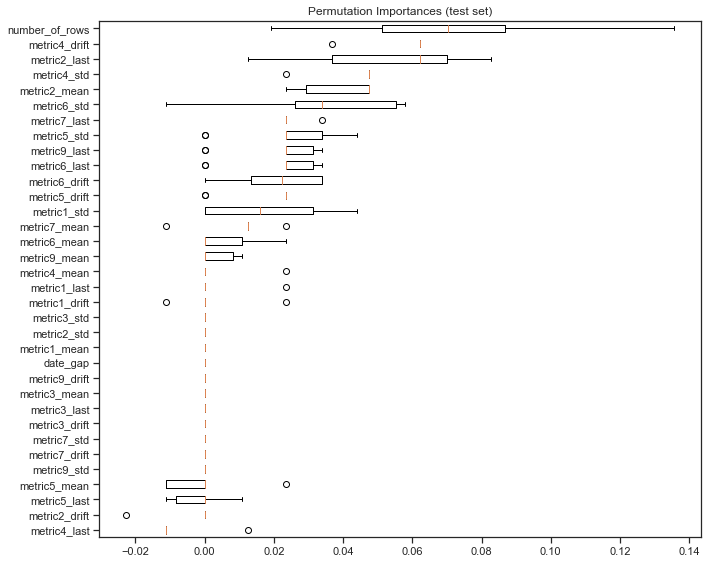

In [76]:
result = permutation_importance(grid_rf_f, X_data_test, y_data_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_data.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [77]:
perm_feature = pd.concat([pd.DataFrame(X_data.columns),pd.DataFrame(result.importances_mean)], axis = 1)
perm_feature.columns=['feature','imp']
req_index = perm_feature.sort_values('imp', ascending=False).head(10).index
req_X_data_train = X_data_train[:,req_index]
req_X_data_test = X_data_test[:,req_index]
grid_rf_f_req.fit(req_X_data_train,y_data_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[[309   9]
 [ 14  19]]


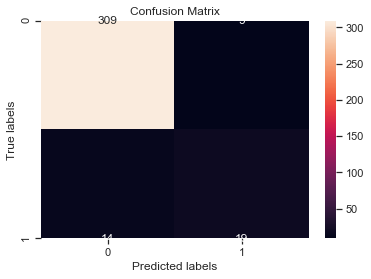

In [78]:
cm = confusion_matrix(y_data_test, grid_rf_f_req.predict(req_X_data_test),labels)

print(cm)

ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');

ax.set_title('Confusion Matrix');

ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

# Module 13: Precision Recall curve

In [79]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt


In [80]:
precision, recall, thresholds = precision_recall_curve(y_data_test, grid_rf_f.predict_proba(X_data_test)[:,1])

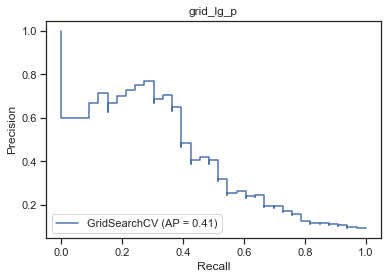

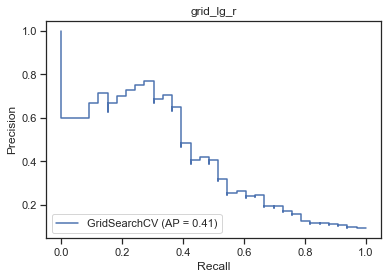

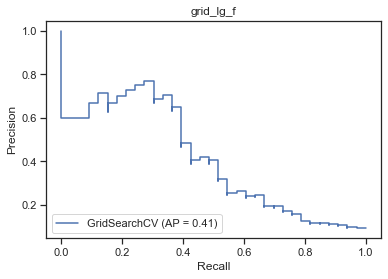

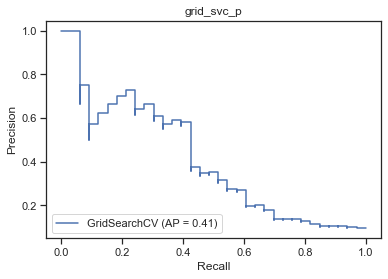

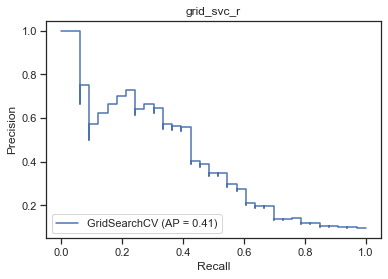

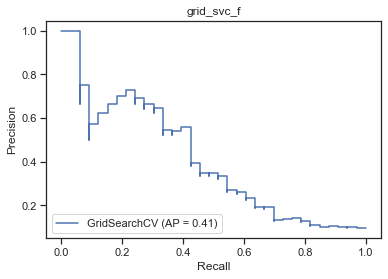

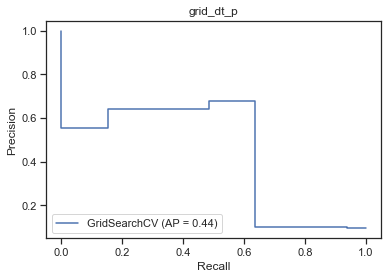

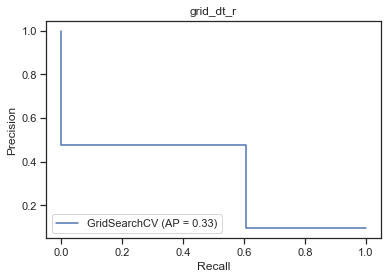

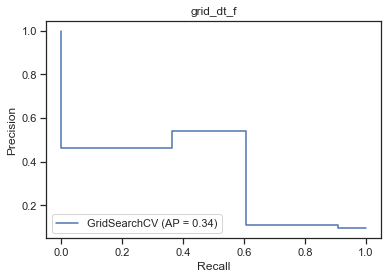

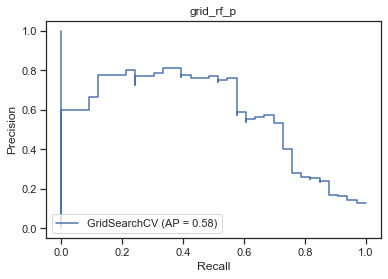

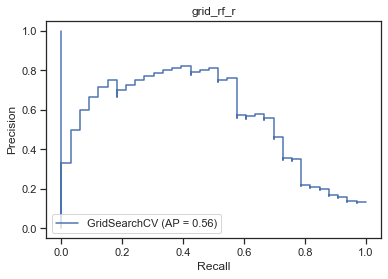

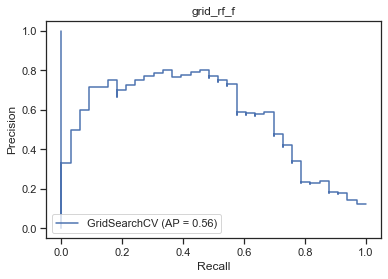

In [81]:
#fig = plt.figure(figsize=(20,15))
cols_val = 3
rows = 5
mod1=['grid_lg_p','grid_lg_r','grid_lg_f','grid_svc_p','grid_svc_r','grid_svc_f','grid_dt_p','grid_dt_r','grid_dt_f','grid_rf_p','grid_rf_r','grid_rf_f']
mod=[grid_lg_p,grid_lg_r,grid_lg_f,grid_svc_p,grid_svc_r,grid_svc_f,grid_dt_p,grid_dt_r,grid_dt_f,grid_rf_p,grid_rf_r,grid_rf_f]
for i, model_data in enumerate(mod):
    #ax = fig.add_subplot(rows, cols_val, i + 1)
    disp =plot_precision_recall_curve(model_data, X_data_test, y_data_test)
    #cm = confusion_matrix(y_data_test, model_pred,labels)
    #sns.heatmap(cm, annot=True, fmt='g'); #annot=True to annotate cells
   # labels, title and ticks

    #plt.xlabel('Predicted labels');plt.ylabel('True labels');

    plt.title(mod1[i]);

    #ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);
    
#plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()

# Module 14: Probalistic Scores

In [ ]:
test_indx.reset_index(drop=True, inplace = True)
device_name['idx']= device_name.index

In [116]:
y_data_test_merge = y_data_test.reset_index(drop=True)

In [117]:
probabilistic_result = pd.concat([pd.DataFrame(grid_rf_f.predict_proba(X_data_test),columns=['probability_0','probability_1']),pd.merge(test_indx,device_name),y_data_test_merge], axis = 1)

In [118]:
probabilistic_result.drop(['idx'], axis =1, inplace = True)

In [121]:
probabilistic_result.rename(columns={'failure':'Predicted'}, inplace = True)

In [122]:
probabilistic_result.to_csv('predicted_probalistic_values.csv')